In [31]:
#import the libraries 
import os 
import pandas as pd
import numpy as np  # linear algebra
import cv2  # Use OpenCV for faster image processing  
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import train_test_split  
from sklearn.decomposition import PCA  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
import matplotlib.pyplot as plt  
import seaborn as sns  
from tqdm import tqdm 
import csv
import scipy.io
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss 

In [32]:
# function to Extract dataset  
def extract_dataset(zip_path, extract_to="flowers_dataset"): 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:  
        zip_ref.extractall(extract_to)  
    print(f"Dataset extracted to {extract_to}")  

dataset_path = "D:/archive.zip"
extract_dataset(dataset_path)  

Dataset extracted to flowers_dataset


In [33]:
# Load and preprocess dataset  
def load_data(data_dir, image_size=(128, 128)):  
    classes = os.listdir(data_dir)  # Folder names = class names  
    features = []  
    labels = []  

    for class_name in tqdm(classes, desc="Loading Data"):  # Loop over each class  
        class_dir = os.path.join(data_dir, class_name)  
        for img_name in os.listdir(class_dir):  
            try:  
                img_path = os.path.join(class_dir, img_name)  
                img = cv2.imread(img_path)  # Use OpenCV to read the image  
                img = cv2.resize(img, image_size)  # Resize to 128x128  
                features.append(img)  # Append image array  
                labels.append(class_name)  # Append label  
            except Exception as e:  
                print(f"Error loading image {img_path}: {e}")  
    return np.array(features), np.array(labels)  
 
data_dir = "flowers_dataset/flowers"  
X, y = load_data(data_dir)  

Loading Data: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.35s/it]


In [34]:
# Normalize pixel values and convert to float32  
X = (X / 255.0).astype('float32')

In [35]:
# Encode labels  
def encode_labels(y):  
    label_encoder = LabelEncoder()  
    y_encoded = label_encoder.fit_transform(y)  
    return y_encoded, label_encoder  

y_encoded, label_encoder = encode_labels(y)

In [36]:
# Split dataset into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [37]:
# Flatten images for PCA  
X_train_flatten = X_train.reshape(X_train.shape[0], -1)  
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [38]:
# Apply PCA for dimensionality reduction  
def apply_pca(X_train, X_test, n_components=50):
    pca = PCA(n_components=n_components)  
    X_train_pca = pca.fit_transform(X_train)  
    X_test_pca = pca.transform(X_test)  
    return X_train_pca, X_test_pca, pca  

X_train_pca, X_test_pca, pca = apply_pca(X_train_flatten, X_test_flatten, n_components=15)

In [39]:
# Train using KNN classifier
knn = KNeighborsClassifier(n_neighbors=6, metric='manhattan')  
knn.fit(X_train_pca, y_train)  
y_pred = knn.predict(X_test_pca)

In [40]:
#print accurecy and precision and recall
accuracy = accuracy_score(y_test, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")  
print("\nClassification Report:")  
print(classification_report(y_test, y_pred))

Accuracy: 48.50%

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.54      0.47       153
           1       0.46      0.51      0.49       210
           2       0.49      0.35      0.41       157
           3       0.60      0.63      0.61       147
           4       0.49      0.42      0.45       197

    accuracy                           0.48       864
   macro avg       0.49      0.49      0.49       864
weighted avg       0.49      0.48      0.48       864



In [41]:
#print loss value
loss = log_loss(y_test, y_pred_proba)  
print(f"Log Loss: {loss:.4f}")

Log Loss: 5.3872


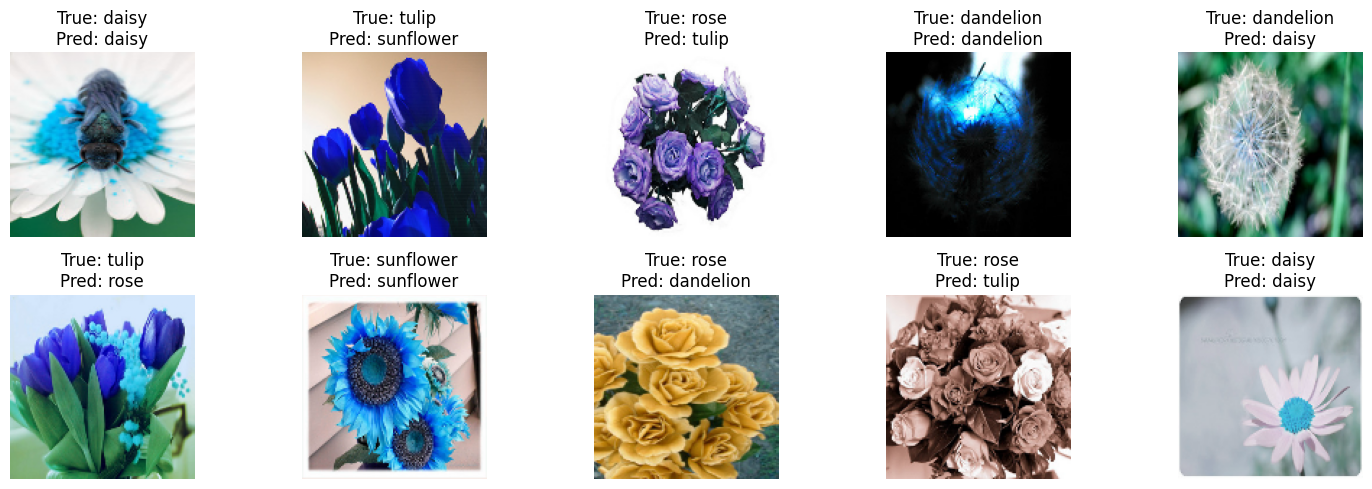

In [42]:
# Visualize predictions  
def visualize_predictions(X, y_true, y_pred, label_encoder, num_images=10):    
    indices = np.random.choice(range(len(X)), num_images, replace=False)  
    plt.figure(figsize=(15, 5))  
    for i, idx in enumerate(indices):  
        plt.subplot(2, 5, i + 1)  
        plt.imshow(X[idx])  
        plt.title(  
            f"True: {label_encoder.inverse_transform([y_true[idx]])[0]}\nPred: {label_encoder.inverse_transform([y_pred[idx]])[0]}"  
        )  
        plt.axis('off')  
    plt.tight_layout()  
    plt.show()  

visualize_predictions(X_test, y_test, y_pred, label_encoder)

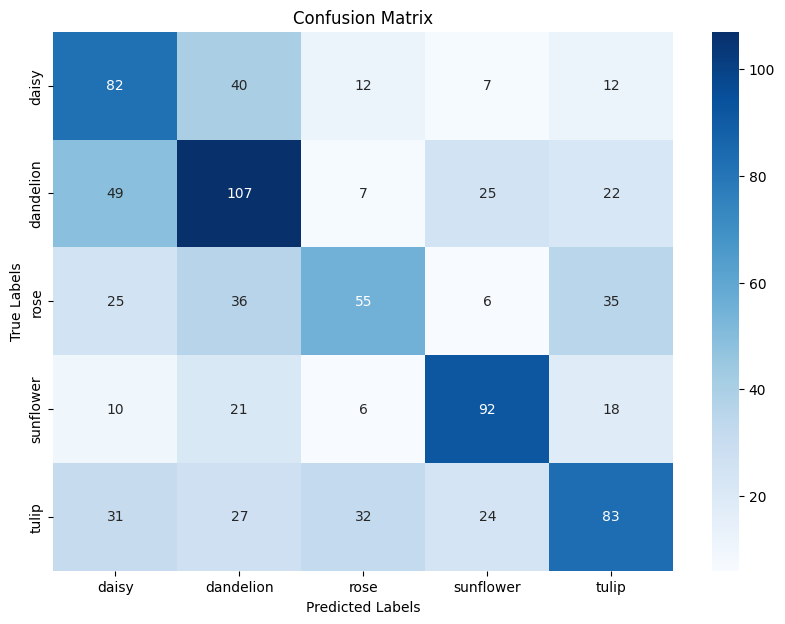

In [43]:
# Plot Confusion Matrix  
def plot_confusion_matrix(y_true, y_pred, label_encoder):   
    cm = confusion_matrix(y_true, y_pred)  
    plt.figure(figsize=(10, 7))  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)  
    plt.xlabel('Predicted Labels')  
    plt.ylabel('True Labels')  
    plt.title('Confusion Matrix')  
    plt.show()  

plot_confusion_matrix(y_test, y_pred, label_encoder)

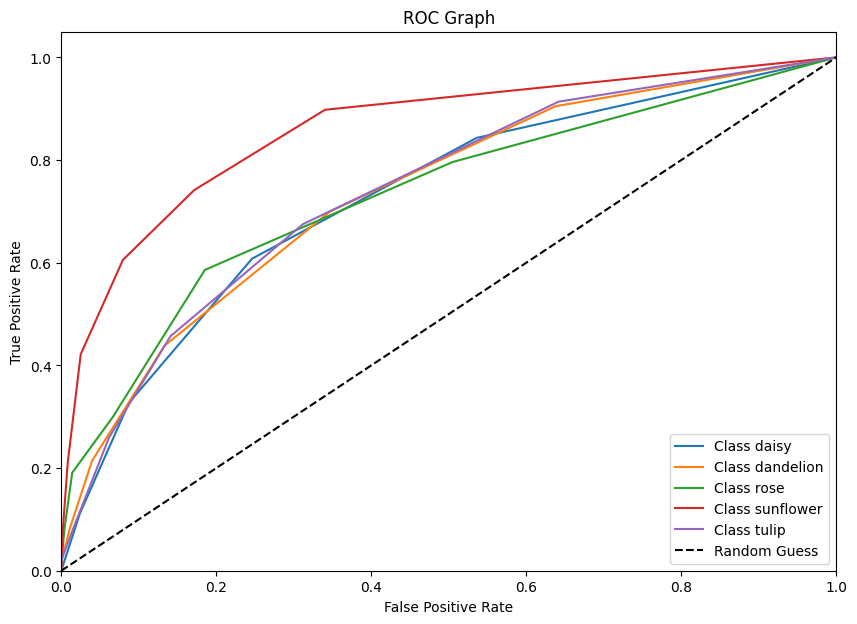

In [44]:
# Get predicted probabilities from the KNN model  
y_pred_proba = knn.predict_proba(X_test_pca)  

# Plot ROC Graph  
num_classes = len(label_encoder.classes_)  
y_true_onehot = np.eye(num_classes)[y_test]  

plt.figure(figsize=(10, 7))  
for i in range(num_classes):  
    # Compute ROC curve for each class  
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])  
    plt.plot(fpr, tpr, label=f"Class {label_encoder.classes_[i]}")  

# Plot the diagonal line for random guessing  
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('ROC Graph')  
plt.legend(loc="lower right")  
plt.show()  

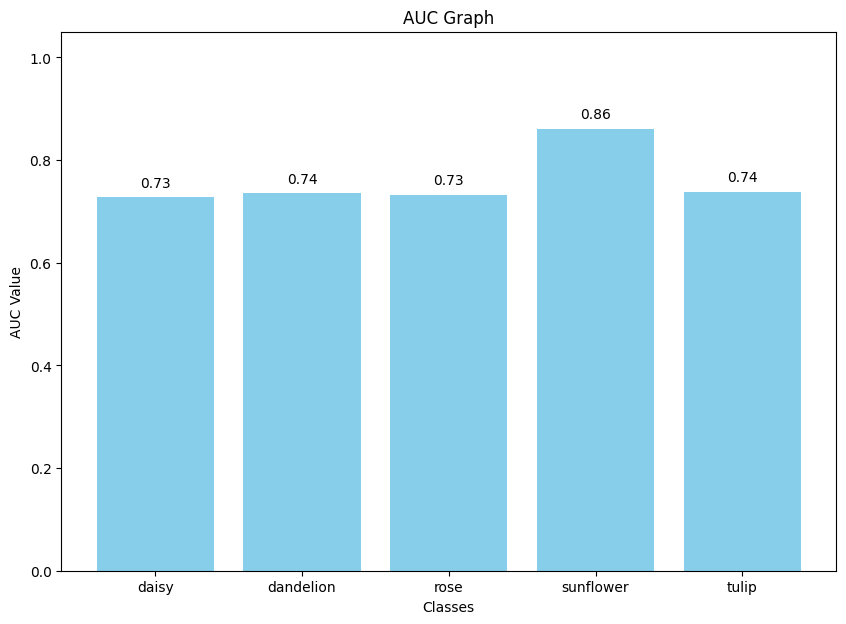

In [45]:
# Plot AUC Graph  
auc_values = []  
for i in range(num_classes):  
    # Compute ROC curve and AUC for each class  
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])  
    roc_auc = auc(fpr, tpr)  
    auc_values.append(roc_auc)  

# Plot AUC values as a bar chart  
plt.figure(figsize=(10, 7))  
plt.bar(label_encoder.classes_, auc_values, color='skyblue')  
plt.ylim([0.0, 1.05])  
plt.xlabel('Classes')  
plt.ylabel('AUC Value')  
plt.title('AUC Graph')  
for i, v in enumerate(auc_values):  
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)  
plt.show()